Matthieu SCHLIENGER

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/navire-2022-libre/ships.tgz


In [2]:
!tar xzf /kaggle/input/navire-2022-libre/ships.tgz

In [3]:
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [4]:
!ls /kaggle/working

__notebook__.ipynb  ships32  ships_competition.npz


In [5]:
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Lire les images

In [6]:
image_size = (32, 32)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/ships32",
    validation_split=0.1,
    subset="training",
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/working/ships32",
    validation_split=0.1,
    subset="validation",
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size,
)

Found 51284 files belonging to 13 classes.
Using 46156 files for training.


2022-07-10 21:52:54.773209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 21:52:54.859411: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 21:52:54.860214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-10 21:52:54.866363: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Found 51284 files belonging to 13 classes.
Using 5128 files for validation.


# Configuration du modèle

#### Pour avoir des pérformances optimales nous allons utiliser dans ce cas-ci le transfert learning. Le transfert learning utilise un modèle pré-entrainé comme point de départ du modèle principale et va rajouter des couches à la suite.
#### Le VGG-16 est l'un des modèles pré-entraînés les plus populaires pour la classification d'images.

In [7]:
conv_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))

conv_model.trainable = False

x = tf.keras.layers.Flatten()(conv_model.output)
# three hidden layers
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
# final softmax layer with two categories (dog and cat)
predictions = tf.keras.layers.Dense(13, activation='softmax')(x)



# creating the full model:
full_model = tf.keras.models.Model(inputs=conv_model.input, outputs=predictions)

58900480/58889256 [==============================] - 0s 0us/step


In [8]:
full_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [9]:
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=4, restore_best_weights=True)

# save best model indicating epoch
model_save = ModelCheckpoint('./weights/Custom_model_{epoch}.h5',
                             save_best_only=True, monitor='val_loss', verbose=1)
# Folder to save weights
if not os.path.exists('./weights'):
    os.makedirs('./weights', mode=0o770, exist_ok=True)
    
# reduce learning rate if val_loss does not decrease in 2 epochs, cooldown of 1 epoch
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, cooldown=1, verbose=1)

# Entrainement de notre modèle

#### Une étape supplémentaire du transfer learning est le fine-tunning qui consiste à dégeler l'ensemble du modèle une fois entrainé, et à le réentraîner sur les nouvelles données avec un taux d'apprentissage très faible.
#### On entraine donc une première fois notre modèle gelé

In [10]:
full_model.compile(optimizer=Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history1 = full_model.fit(train_ds, callbacks=[early_stopping, model_save, reduce_lr], validation_data=val_ds, epochs=20)

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20


2022-07-10 21:53:00.297781: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-07-10 21:53:01.138139: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1443/1443 [==============================] - 20s 9ms/step - loss: 2.2518 - accuracy: 0.3473 - val_loss: 1.8265 - val_accuracy: 0.3906

Epoch 00001: val_loss improved from inf to 1.82654, saving model to ./weights/Custom_model_1.h5
Epoch 2/20
1443/1443 [==============================] - 13s 9ms/step - loss: 1.7253 - accuracy: 0.4303 - val_loss: 1.7395 - val_accuracy: 0.4175

Epoch 00002: val_loss improved from 1.82654 to 1.73954, saving model to ./weights/Custom_model_2.h5
Epoch 3/20
1443/1443 [==============================] - 13s 9ms/step - loss: 1.6315 - accuracy: 0.4587 - val_loss: 1.7128 - val_accuracy: 0.4282

Epoch 00003: val_loss improved from 1.73954 to 1.71276, saving model to ./weights/Custom_model_3.h5
Epoch 4/20
1443/1443 [==============================] - 13s 9ms/step - loss: 1.5696 - accuracy: 0.4789 - val_loss: 1.7177 - val_accuracy: 0.4343

Epoch 00004: val_loss did not improve from 1.71276
Epoch 5/20
1443/1443 [==============================] - 13s 9ms/step - loss: 1.5

#### On dégèle notre modèle pour le réentraîner

In [11]:
conv_model.trainable = True

In [12]:
full_model.compile(optimizer=Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history2 = full_model.fit(train_ds, callbacks=[early_stopping, model_save, reduce_lr], validation_data=val_ds, epochs=10)

Epoch 1/10
1443/1443 [==============================] - 30s 20ms/step - loss: 1.3462 - accuracy: 0.5465 - val_loss: 1.0040 - val_accuracy: 0.6595

Epoch 00001: val_loss improved from 1.68281 to 1.00399, saving model to ./weights/Custom_model_1.h5
Epoch 2/10
1443/1443 [==============================] - 29s 20ms/step - loss: 0.8969 - accuracy: 0.6900 - val_loss: 0.8893 - val_accuracy: 0.7126

Epoch 00002: val_loss improved from 1.00399 to 0.88928, saving model to ./weights/Custom_model_2.h5
Epoch 3/10
1443/1443 [==============================] - 29s 20ms/step - loss: 0.7007 - accuracy: 0.7558 - val_loss: 0.8281 - val_accuracy: 0.7274

Epoch 00003: val_loss improved from 0.88928 to 0.82810, saving model to ./weights/Custom_model_3.h5
Epoch 4/10
1443/1443 [==============================] - 28s 20ms/step - loss: 0.5583 - accuracy: 0.7991 - val_loss: 0.8978 - val_accuracy: 0.7309

Epoch 00004: val_loss did not improve from 0.82810
Epoch 5/10
1443/1443 [==============================] - 29s 2

# Analyse du modèle

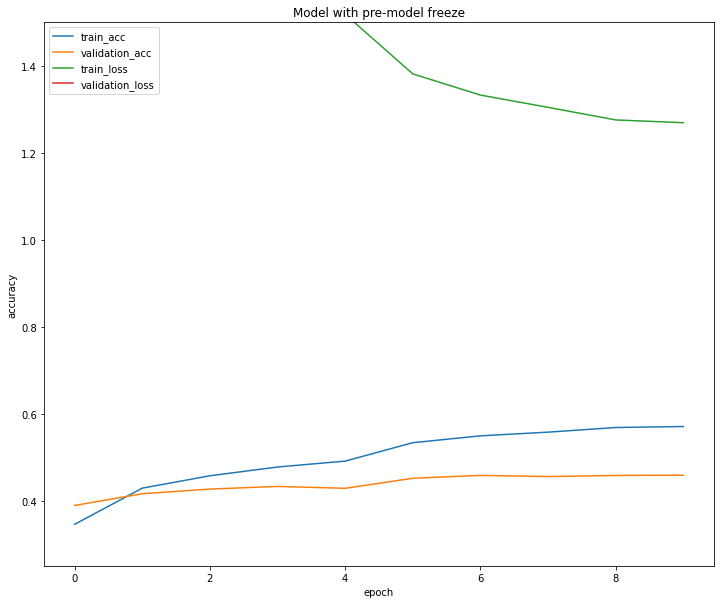

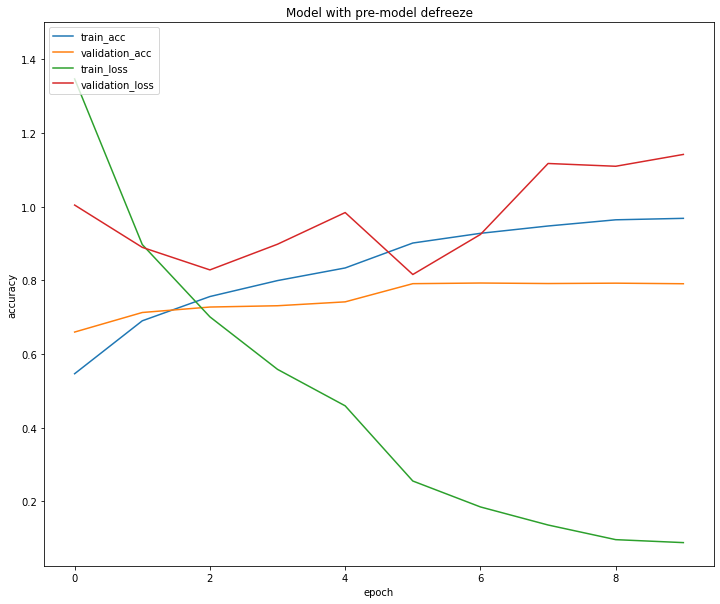

In [13]:
import matplotlib.pyplot as plt

def plot_hist(hist, name):
        """Plots training chart"""
        plt.figure(figsize=[12, 10])
        plt.plot(hist.history["accuracy"])
        plt.plot(hist.history["val_accuracy"])
        plt.plot(hist.history["loss"])
        plt.plot(hist.history["val_loss"])
        plt.title(f"{name}")
        plt.ylabel("accuracy")
        plt.xlabel("epoch")
        plt.ylim(top=1.5)
        plt.legend(["train_acc", "validation_acc", "train_loss", "validation_loss"], loc="upper left")
        plt.savefig(f'{name}_chart.png')
        plt.show()

plot_hist(history1, name='Model with pre-model freeze')
plot_hist(history2, name='Model with pre-model defreeze')

# Résultat à soumettre

In [14]:
X_test = np.load('/kaggle/working/ships_competition.npz', allow_pickle=True)['X']
#X_test = X_test.astype('float32') / 255

In [15]:
res = full_model.predict(X_test).argmax(axis=1)
df = pd.DataFrame({"Category":res})
df.to_csv("submission.csv", index_label="Id")

In [16]:
!head submission.csv

Id,Category
0,5
1,5
2,7
3,11
4,0
5,5
6,4
7,5
8,7


In [17]:
import os
os.chdir(r'/kaggle/working')
from IPython.display import FileLink
FileLink(r'submission.csv')

/kaggle/working/submission.csv

In [18]:
!rm -rf ships32/